<a href="https://colab.research.google.com/github/ZhumabaevErkin/catvsdog/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Hackaton_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Установка необходимых библиотек
!pip install kaggle tensorflow matplotlib seaborn numpy pandas

# Подключение Kaggle API и скачивание датасета
import os
import shutil

# Установка Kaggle API
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

# Скачивание датасета
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis
!unzip chest-xray-pneumoniacovid19tuberculosis.zip -d dataset


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/train/NORMAL/NORMAL2-IM-0843-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0845-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0846-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0847-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0848-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0849-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001-0002.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0851-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0852-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0854-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0855-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0856-0001.jpeg  
  inflating: dataset/train/NORMAL/NORMAL2-IM-0857-0001

In [6]:
import os

# Просмотр структуры загруженных данных
for set_name in ['train', 'val', 'test']:
    print(f'--- {set_name.upper()} ---')
    set_path = os.path.join(data_dir, set_name)
    for category in os.listdir(set_path):
        print(f'{set_name} -> {category}')


--- TRAIN ---
train -> PNEUMONIA
train -> TURBERCULOSIS
train -> NORMAL
train -> COVID19
--- VAL ---
val -> PNEUMONIA
val -> TURBERCULOSIS
val -> NORMAL
val -> COVID19
--- TEST ---
test -> PNEUMONIA
test -> TURBERCULOSIS
test -> NORMAL
test -> COVID19


In [7]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# Параметры
data_dir = 'dataset'
categories = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 40

# Подсчёт изображений в каждой категории
sets = ['train', 'val', 'test']
for set_name in sets:
    print(f'--- {set_name.upper()} SET ---')
    for category in categories:
        path = os.path.join(data_dir, set_name, category)
        count = len(os.listdir(path))
        print(f'{category}: {count}')
    print()



--- TRAIN SET ---
COVID19: 460
NORMAL: 1341
PNEUMONIA: 3875
TURBERCULOSIS: 650

--- VAL SET ---
COVID19: 10
NORMAL: 8
PNEUMONIA: 8
TURBERCULOSIS: 12

--- TEST SET ---
COVID19: 106
NORMAL: 234
PNEUMONIA: 390
TURBERCULOSIS: 41



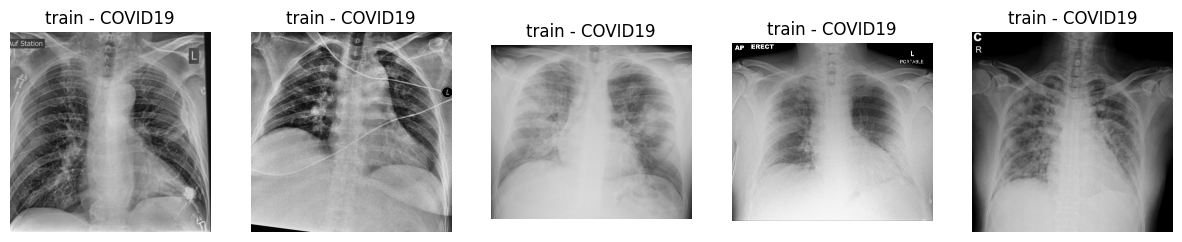

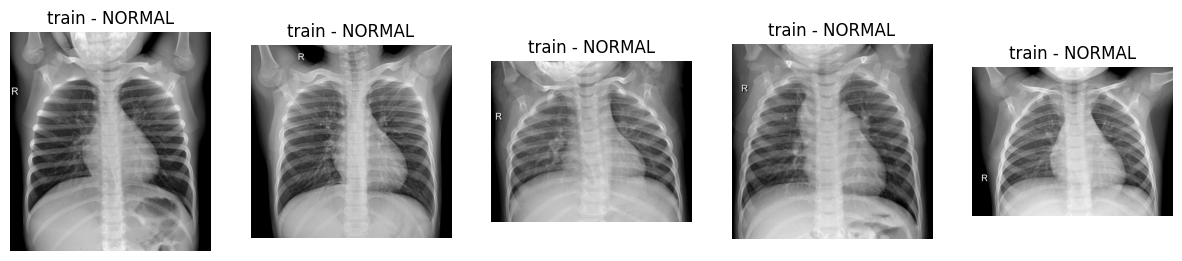

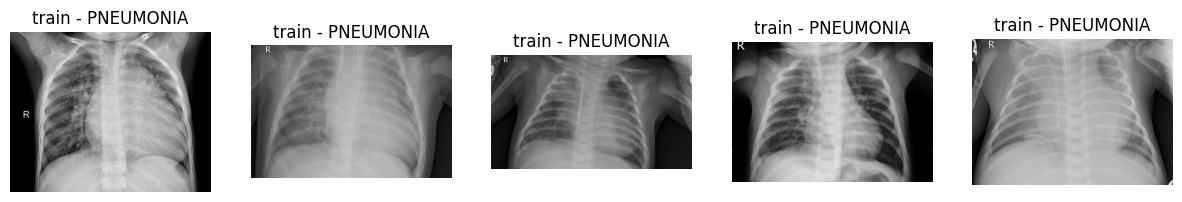

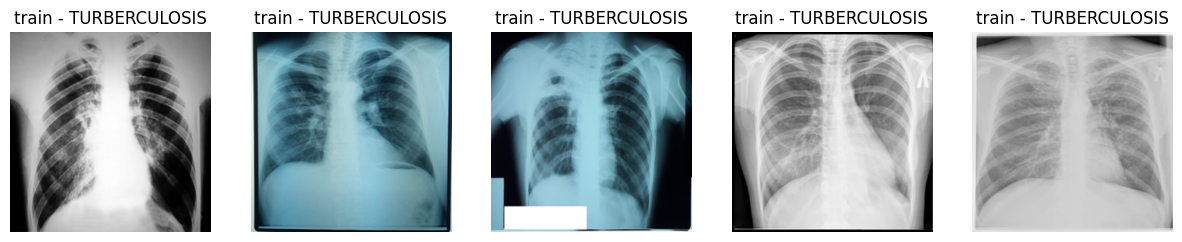

In [8]:
# Визуализация примеров изображений
def display_samples(set_name, category, num_samples=5):
    path = os.path.join(data_dir, set_name, category)
    images = os.listdir(path)[:num_samples]
    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(images):
        img = plt.imread(os.path.join(path, img_name))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{set_name} - {category}')
        plt.axis('off')
    plt.show()

for category in categories:
    display_samples('train', category)



In [9]:
# Генераторы данных
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [10]:
# Вычисление весов классов
train_labels = train_generator.classes
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_vals))
print("Веса классов:", class_weights)


Веса классов: {0: 3.4380434782608695, 1: 1.1793437733035048, 2: 0.4081290322580645, 3: 2.433076923076923}


In [11]:
# Модель с L2-регуляризацией
num_classes = len(categories)
base_model = DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 195s 831ms/step - accuracy: 0.3520 - loss: 1.6454 - val_accuracy: 0.4211 - val_loss: 1.1789
Epoch 2/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 156s 676ms/step - accuracy: 0.4712 - loss: 1.2357 - val_accuracy: 0.5526 - val_loss: 0.9665
Epoch 3/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 145s 691ms/step - accuracy: 0.5644 - loss: 1.0933 - val_accuracy: 0.6842 - val_loss: 0.8088
Epoch 4/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 139s 664ms/step - accuracy: 0.6469 - loss: 0.8959 - val_accuracy: 0.8421 - val_loss: 0.7033
Epoch 5/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 657ms/step - accuracy: 0.7189 - loss: 0.7523 - val_accuracy: 0.8421 - val_loss: 0.6393
Epoch 6/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 666ms/step - accuracy: 0.7150 - loss: 0.7275 - val_accuracy: 0.8684 - val_loss: 0.5747
Epoch 7/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 660ms/step - accuracy: 0.7574 - loss: 0.6611 - val_accuracy: 0.8684 - val_loss: 0.5473
Epoch 8/40
198/198 ━━━━━━━━━━━━━━━━━━━━ 144s 670ms/step - accuracy: 0.7504 - loss: 0.62

In [14]:
# Оценка модели
test_loss, test_acc = model.evaluate(test_generator)
print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step - accuracy: 0.8973 - loss: 0.3353
Точность на тестовых данных: 88.59%


In [34]:
!ls dataset/train


COVID19  NORMAL  PNEUMONIA  TURBERCULOSIS


In [39]:
from google.colab import files
from PIL import Image
import numpy as np
import keras  # Импортируем keras для загрузки модели

# Загрузка изображения через файловый интерфейс Google Colab
uploaded = files.upload()

# Функция для мультимодальной диагностики
def multimodal_analysis(image_path):
    IMG_WIDTH, IMG_HEIGHT = 224, 224  # Размеры для модели (например, для DenseNet)

    # Открытие изображения
    image = Image.open(image_path).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))  # Преобразуем в RGB
    image = np.array(image) / 255.0  # Нормализация пикселей
    image = np.expand_dims(image, axis=0)  # Добавляем размерность для батча


    model = keras.models.load_model('best_model.keras')
    prediction = model.predict(image)


    print(f'Предсказание: {prediction}')

uploaded_image_path = next(iter(uploaded))
multimodal_analysis(uploaded_image_path)


Saving pnevmo2.jpg to pnevmo2 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Предсказание: [[0.74051666 0.00427441 0.02070791 0.23450106]]


In [40]:
train_labels = train_generator.classes

class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights_vals))
print("Веса классов:", class_weights)


Веса классов: {0: 3.4380434782608695, 1: 1.1793437733035048, 2: 0.4081290322580645, 3: 2.433076923076923}


In [42]:
num_classes = len(categories)

base_model = DenseNet121(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2
import tensorflow as tf


base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


num_classes = 4

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))
])

# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Выводим сводку модели
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [52]:
from google.colab import files

# Скачать модель
files.download('best_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>